In [1]:
import numpy as np
import tensorflow as tf

# 랜덤 시드 설정
np.random.seed(0)
tf.random.set_seed(0)

2023-01-25 12:42:44.431975: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-25 12:42:44.540198: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from tensorflow.keras import datasets
(X_train0, y_train0), (X_test0, y_test0) = datasets.mnist.load_data()

Original data 차원 확인

In [3]:
print(X_train0.shape, y_train0.shape)
print(X_test0.shape, y_test0.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


Original data 시각화

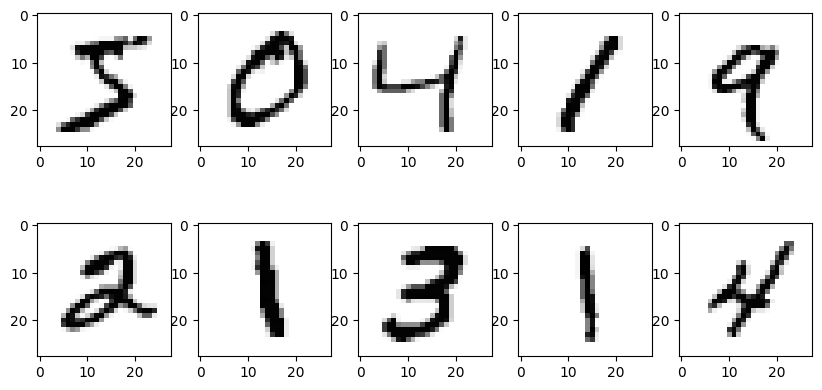

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5)) # plot 크기를 정한다.
for i in range(2*5):
    plt.subplot(2, 5, i+1)  # subplot 설정
    plt.imshow(X_train0[i].reshape((28, 28)), cmap='Greys')
plt.show()

feature data scale 조정

In [5]:
X_train = (X_train0.reshape(60000, 28, 28, 1)) / 255
X_test = (X_test0.reshape(10000, 28, 28, 1)) / 255

# (이미지 개수, 가로, 세로, 채널수)
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


Noise feature data

dataset에서 noise데이터가 제공하지 않으므로
직접 noise데이터를 생성할 수 있다.

np.random.uniform()함수로 균일분포로 랜덤값을 추출하며
랜덤값은 -1~1사이로 하고, 배열사이즈는 train_data의 차원과 일치시킨다.

In [6]:
import numpy as np

X_train_noise = X_train + np.random.uniform(-1, 1, size=X_train.shape)
X_test_noise = X_test + np.random.uniform(-1, 1, size=X_test.shape)

Noise data Scaling
noise를 생성하는 과정에서 pixel값이 0이하, 1이상이 될 가능성이 존재
따라서 numpy의 clip함수를 사용해 값의 범위 조정을 할 수 있다.

In [7]:
X_train_ns = np.clip(X_train_noise, a_min = 0, a_max = 1)
X_test_ns = np.clip(X_test_noise, a_min = 0, a_max = 1)

Noise data 시각화 - 코드는 동일, plot을 그릴ㄷ 때 쓰이는 데이터만 X_train_ns로 바꿔주면 됨

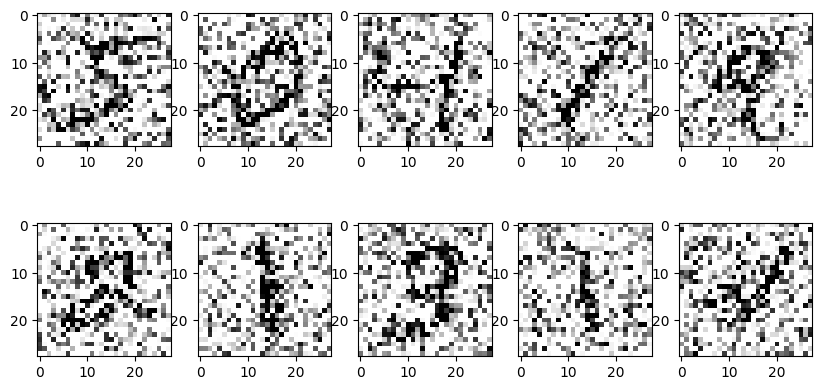

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
for i in range(2*5):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_train_ns[i].reshape((28, 28)), cmap='Greys')
plt.show()

Encoder Model 생성

In [9]:
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, UpSampling2D, Activation

# Encoder
input1 = Input(shape=(28, 28, 1))

x1 = Conv2D(20, (5,5), padding='same', activation='relu')(input1)

output1 = MaxPool2D(pool_size=2, padding='same')(x1)

encoder = Model(input1, output1)
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 20)        520       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 20)       0         
 )                                                               
                                                                 
Total params: 520
Trainable params: 520
Non-trainable params: 0
_________________________________________________________________


2023-01-25 12:42:48.175821: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 12:42:48.177686: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 12:42:48.177824: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 12:42:48.178126: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Encoder Output 차원 확인

In [10]:
print(output1.shape)

(None, 14, 14, 20)


Decoder Model 생성

In [11]:
input2 = Input(shape=output1.shape[1:4])    # 입력층 데이터의 차원은 앞서 생성한 인코더의 아웃풋 차원과 동일

x2 = Conv2D(10, (5,5), padding='same', activation='relu')(input2)    # 출력개수는 10개
x2 = UpSampling2D()(x2)

output2 = Conv2D(1, (5,5), padding='same', activation='relu')(x2)

decoder = Model(input2, output2)
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 14, 14, 20)]      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 10)        5010      
                                                                 
 up_sampling2d (UpSampling2D  (None, 28, 28, 10)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         251       
                                                                 
Total params: 5,261
Trainable params: 5,261
Non-trainable params: 0
_________________________________________________________________


Auto-Encoder Model 생성
- 오토 인코더는 encoder에 입력되는 입력층의 크기와 동일한 입력값을 encoder에 넣고
- 결과로 나온 output을 다시 decoder에 넣는다.
- 오토 인코더는 오토인코더의 입력층과 출력층을 넣고 생성한다.

In [12]:
input_auto = Input(shape=(28, 28, 1))
output_auto = decoder(encoder(input_auto))
auto_encoder = Model(input_auto, output_auto)

auto_encoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 model (Functional)          (None, 14, 14, 20)        520       
                                                                 
 model_1 (Functional)        (None, 28, 28, 1)         5261      
                                                                 
Total params: 5,781
Trainable params: 5,781
Non-trainable params: 0
_________________________________________________________________


Model 컴파일

In [13]:
auto_encoder.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

학습
- feature data: noise가 추가된 feature data
- target data: noise가 없는 original feature training data

In [14]:
hist = auto_encoder.fit(X_train_ns, X_train, epochs=10, batch_size=100)

Epoch 1/10


2023-01-25 12:42:52.364863: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


600/600 [==============================] - 2s 3ms/step - loss: 0.0280 - mean_squared_error: 0.0280
Epoch 2/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0221 - mean_squared_error: 0.0221
Epoch 3/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0210 - mean_squared_error: 0.0210
Epoch 4/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0198 - mean_squared_error: 0.0198
Epoch 5/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0180 - mean_squared_error: 0.0180
Epoch 6/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0167 - mean_squared_error: 0.0167
Epoch 7/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0159 - mean_squared_error: 0.0159
Epoch 8/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0153 - mean_squared_error: 0.0153
Epoch 9/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0148 - mean_squared_error: 0.0148
Epoch 10/10
600/600 [

예측값

In [15]:
X_pred = auto_encoder.predict(X_train_ns)

1875/1875 [==============================] - 2s 1ms/step


Auto-Encoding data 시각화

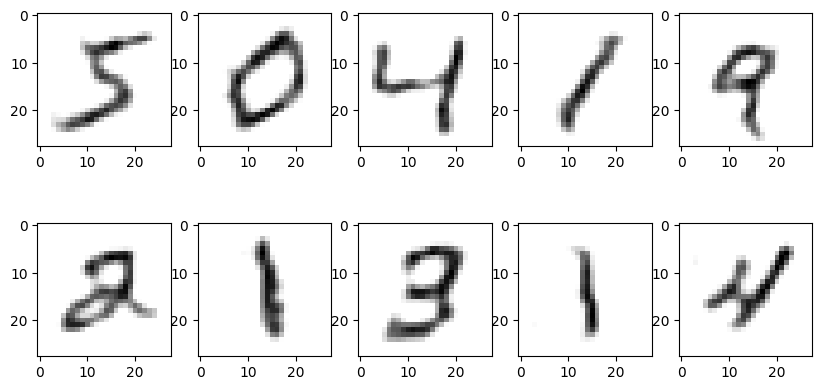

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
for i in range(2*5):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_pred[i].reshape(28, 28), cmap='Greys')
plt.show() # 노이즈를 제거하기 전보다 훨씬 보기 좋아졌음을 알 수 있다.